# Time Series Classification Algorithms - (0) Datasets

<div style="border: 1px solid #007acc; background-color: #e6f4ff; padding: 10px; border-radius: 5px; color: black;">
  <strong>📘 Info:</strong> I do not claim ownership of the content in this notebook. It is based on official <a href="https://www.aeon-toolkit.org/en/latest/examples.html" target="_blank">aeon tutorials</a>, and parts of the code or text may have been copy-pasted or adapted directly from those or other sources for learning purposes.
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import skimage as ski

In [3]:
from aeon.datasets import get_dataset_meta_data, load_classification
from aeon.visualisation import plot_series, plot_collection_by_class

# from aeon.datasets.dataset_collections import get_available_tsc_datasets
# get_available_tsc_datasets()

## 1. Time Series Classification

Time Series Classification (TSC) involves training a model from a collection of time series (real valued, ordered, data) in order to predict a discrete target variable. For example, we might want to build a model that can predict whether a patient is sick based on their ECG reading, or a persons type of movement based on the trace of the position of their hand. 

<img src="images/00_tsc.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

Time series can be univariate (each observation is a single value) or multivariate (each observation is a vector). For example, an ECG reading from a single sensor is a univariate series, but a motion trace of from a smart watch would be multivariate, with at least three dimensions (x, y, z coordinates).

List of all available datasets [here](https://github.com/aeon-toolkit/aeon/blob/main/aeon/datasets/tsc_datasets.py).

The datasets were chosen based on:

```bibtex
@article{middlehurst2024,
  author = {Middlehurst, Matthew and Sch{\"a}fer, Patrick and Bagnall, Anthony},
  title = {Bake Off Redux: A Review and Experimental Evaluation of Recent Time Series Classification Algorithms},
  journal = {Data Mining and Knowledge Discovery},
  volume = {38},
  pages = {1958--2031},
  year = {2024},
  doi = {10.1007/s10618-024-01022-1},
  url = {https://doi.org/10.1007/s10618-024-01022-1}
}
```

... And other relevant ones.

In [4]:
def get_datasets_and_metadata(dataset_name):
    X, y, info = load_classification(dataset_name, return_metadata=True)

    try:
        metadata = get_dataset_meta_data(data_names=[dataset_name]).reset_index(drop=True)
    except Exception:
        metadata = pd.DataFrame()

    # Handle cases where X or y is a list
    x_shape = getattr(X, "shape", (len(X), "unknown"))
    y_shape = getattr(y, "shape", (len(y),))

    print((
        f"X shape: {x_shape}\n"
        f"y.shape: {y_shape}\n"
    ))

    X_train, y_train = load_classification(dataset_name, split="train")
    X_test, y_test = load_classification(dataset_name, split="test")

    print((
        f"X_train shape: {getattr(X_train, 'shape', (len(X_train), 'unknown'))}\n"
        f"y_train.shape: {getattr(y_train, 'shape', (len(y_train),))}\n"
        f"X_test shape: {getattr(X_test, 'shape', (len(X_test), 'unknown'))}\n"
        f"y_test.shape: {getattr(y_test, 'shape', (len(y_test),))}\n"
    ))

    if metadata.empty:
        sample = X_train.iloc[0] if hasattr(X_train, "iloc") else X_train[0]

        if isinstance(sample, pd.Series) or (hasattr(sample, "ndim") and sample.ndim == 1):
            length = len(sample)
            channels = 1
            data_type = "Univariate"
        else:
            length = sample.shape[-1]
            channels = sample.shape[0]
            data_type = "Multivariate"

        metadata = pd.DataFrame({
            "Dataset": [dataset_name],
            "TrainSize": [len(X_train)],
            "TestSize": [len(X_test)],
            "Length": [length],
            "NumberClasses": [len(np.unique(y_train))],
            "Type": [data_type],
            "Channels": [channels],
        })

    # Handle missing info gracefully
    info_df = pd.DataFrame([{
        'Timestamps': info.get('timestamps', None),
        'Missing': info.get('missing', None),
        'Univariate': info.get('univariate', None),
        'EqualLength': info.get('equallength', None),
        'ClassLabel': info.get('classlabel', None),
        'TargetLabel': info.get('targetlabel', None),
        'ClassValues': info.get('class_values', None),
    }])

    metadata_df = pd.concat([metadata.reset_index(drop=True), info_df], axis=1)

    return X, y, X_train, y_train, X_test, y_test, metadata_df

## 2. Converting Images to Time Series

### 2.1. Radial Scanning

Radial scanning is tricky to explain, but once it clicks you’ll realize that it is both simple and elegant. Here’s an example from a human skull:

<img src="images/00_radialscanning.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

First we find the skull’s outline. Then we find the distance from the center of the skull to each point on the skull’s outline (B). Finally, we plot those distances as a time series (C). The lines connecting the skull to the graph show where that point on the skull maps to the time series below. In this case, we started at the skull’s mouth and went clockwise.Skulls from different species produce different time series:

Skulls from different species produce different time series:

<img src="images/00_radialscanning2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

Take a careful look at these skulls and their time series. Make sure you can spot the differences in the time series between each grouping. Don’t worry yet about how the groupings were made. Right now, just get a feel for how a shape can be converted into a time series.

Another example of radial scanning comes from Korea University. Here we are trying to determine a tree’s species based on it’s leaf shapes:

<img src="images/00_radialscanning3.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

The labeled points on the leaf at left correspond to the labeled positions on the time series at right. Radial scanning is a popular technique for leaf classification because every species of plant has a characteristic leaf shape. Each leaf will be unique, but the pattern of peaks and valleys in the resulting time series should be similar if the species of plant is the same.

We can already tell that the graphs created by the skulls and the leaf look very different to the human eye. This is a good sign that radial scanning captures important information about the objects shape that we will be able to use in the comparison step.

*Source: https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html*

### 2.1.1. Horse Image Example

Below we show and example of Radial Scanning on a Horse Image.
We start by pre-processing the image...

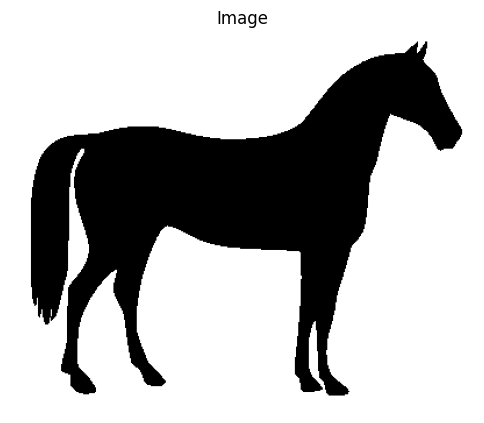

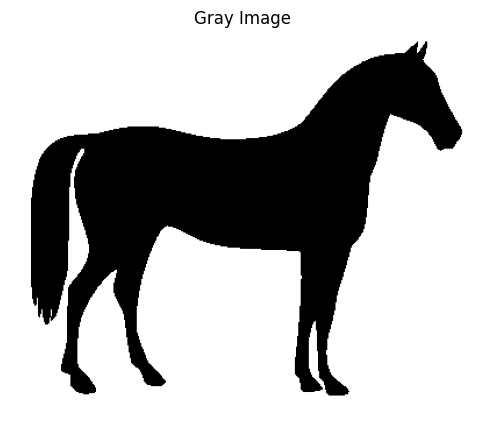

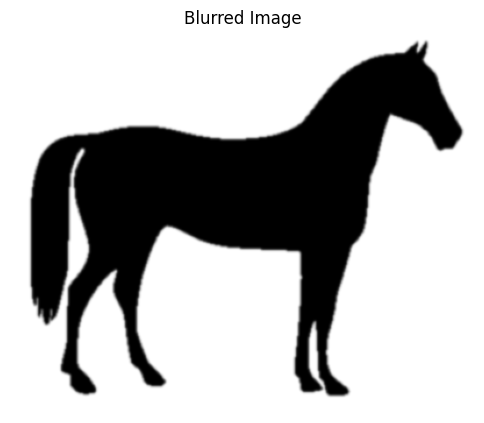

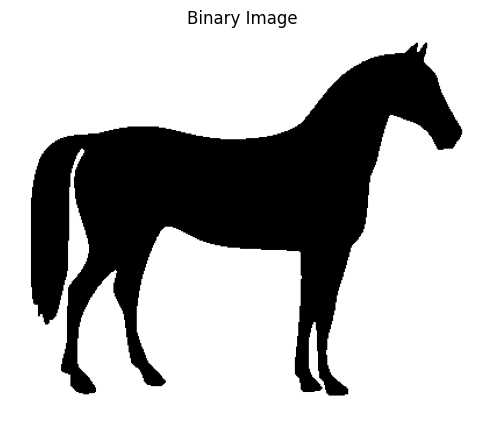

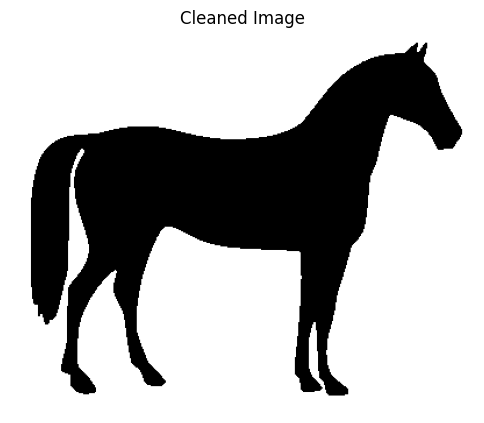

In [5]:
image = ski.data.horse()

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.axis('off')
plt.show()

# Convert to grayscale if it's not already
gray_image = ski.color.rgb2gray(image) if image.ndim == 3 else image

plt.figure(figsize=(6, 6))
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')
plt.show()

# Apply Gaussian blur to reduce noise
blurred_image = ski.filters.gaussian(gray_image, sigma=1.0)

plt.figure(figsize=(6, 6))
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.show()

# Apply Otsu's threshold to binarize the image
threshold_value = ski.filters.threshold_otsu(blurred_image)
binary_image = blurred_image > threshold_value

plt.figure(figsize=(6, 6))
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

# Remove small objects and fill holes
cleaned_image = ski.morphology.remove_small_objects(binary_image, min_size=100)
cleaned_image = ski.morphology.remove_small_holes(cleaned_image, area_threshold=100)
plt.figure(figsize=(6, 6))
plt.imshow(cleaned_image, cmap='gray')
plt.title('Cleaned Image')
plt.axis('off')
plt.show()


Then, we'll identify the largest contour in the binary image, assuming it's the main object of interest.

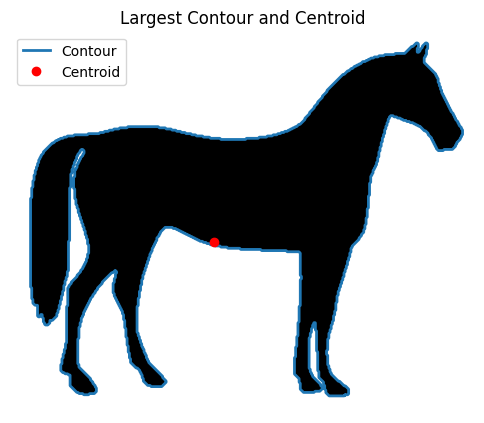

In [6]:
# Find contours in the binary image
contours = ski.measure.find_contours(cleaned_image, level=0.8)

# Select the largest contour based on length
largest_contour = max(contours, key=len)

# Compute the centroid of the contour
centroid = np.mean(largest_contour, axis=0)
cy, cx = centroid

# Display the contour and centroid
plt.figure(figsize=(6, 6))
plt.imshow(cleaned_image, cmap='gray')
plt.plot(largest_contour[:, 1], largest_contour[:, 0], linewidth=2, label='Contour')
plt.plot(cx, cy, 'ro', label='Centroid')
plt.title('Largest Contour and Centroid')
plt.axis('off')
plt.legend()
plt.show()

Now, we perform the radical scanning...

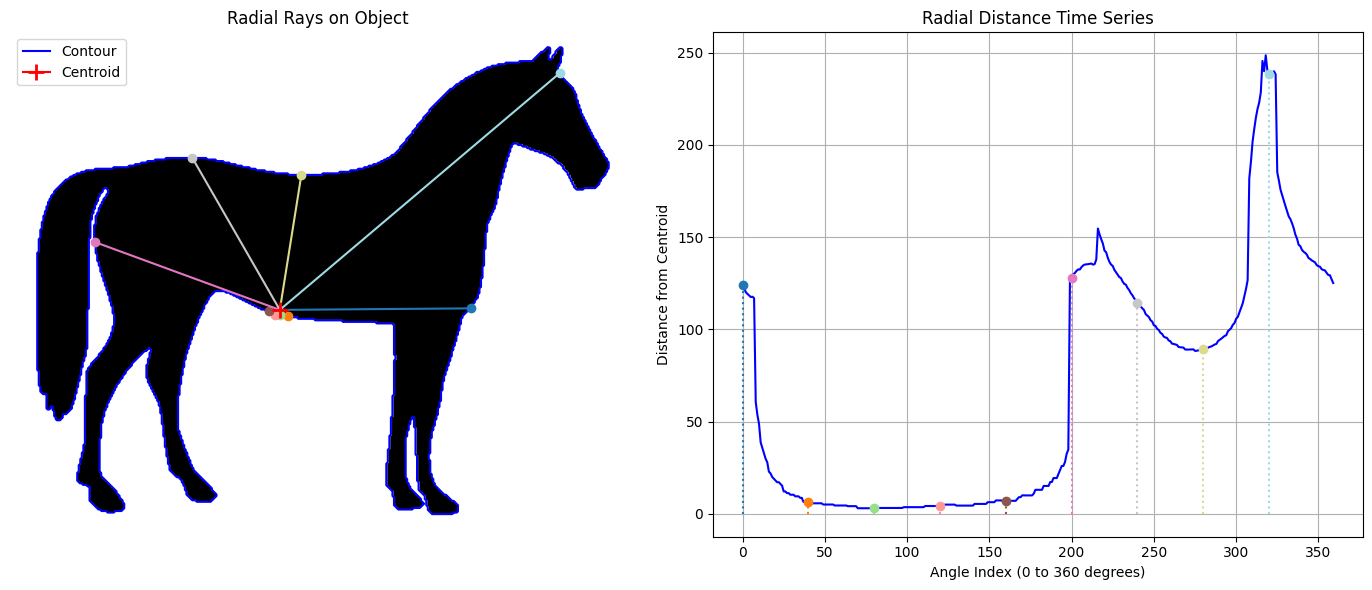

In [7]:
def radial_scan(image, centroid, num_angles=360):
    """
    Perform radial scanning from a centroid across a binary image.
    Returns distances and ray endpoints.
    """
    cx, cy = centroid
    rows, cols = image.shape
    max_radius = np.hypot(rows, cols)
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

    distances = []
    ray_endpoints = []

    for angle in angles:
        y_end = int(cy + max_radius * np.sin(angle))
        x_end = int(cx + max_radius * np.cos(angle))
        rr, cc = ski.draw.line(int(cy), int(cx), y_end, x_end)
        rr = np.clip(rr, 0, rows - 1)
        cc = np.clip(cc, 0, cols - 1)

        for r, c in zip(rr, cc):
            if image[r, c]:
                distances.append(np.hypot(r - cy, c - cx))
                ray_endpoints.append((c, r))  # (x, y)
                break
        else:
            print(f"No hit at angle {np.rad2deg(angle):.1f}°")
            distances.append(0)
            ray_endpoints.append((cc[-1], rr[-1]))

    return np.array(distances), ray_endpoints


def plot_rays_on_shape(image, contour, centroid, ray_endpoints, highlight_indices, ax, cmap='tab20'):
    """
    Plot radial rays on the shape image.
    """
    cx, cy = centroid
    ax.imshow(image, cmap='gray')
    ax.plot(contour[:, 1], contour[:, 0], color='blue', label='Contour')

    colors = plt.get_cmap(cmap, len(highlight_indices))
    for idx, i in enumerate(highlight_indices):
        x_end, y_end = ray_endpoints[i]
        color = colors(idx)
        ax.plot([cx, x_end], [cy, y_end], color=color)
        ax.plot(x_end, y_end, 'o', color=color)

    ax.plot(cx, cy, marker='+', color='red', markersize=12, markeredgewidth=2, label='Centroid')
    ax.set_title("Radial Rays on Object")
    ax.axis('off')
    ax.legend()


def plot_time_series(time_series, highlight_indices, ray_colors, ax):
    """
    Plot the time series and highlight the selected indices.
    """
    ax.plot(time_series, color='blue')
    for idx, i in enumerate(highlight_indices):
        color = ray_colors(idx)
        ax.plot(i, time_series[i], 'o', color=color)
        ax.vlines(i, 0, time_series[i], colors=color, linestyles='dotted')

    ax.set_title("Radial Distance Time Series")
    ax.set_xlabel("Angle Index (0 to 360 degrees)")
    ax.set_ylabel("Distance from Centroid")
    ax.grid(True)


def visualize_radial_scan(image, contour, centroid, num_angles=360, step=40):
    """
    Perform radial scan and display the two-panel plot.
    """
    time_series, ray_endpoints = radial_scan(image, centroid, num_angles=num_angles)
    highlight_indices = list(range(0, num_angles, step))
    color_map = plt.get_cmap('tab20', len(highlight_indices))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    plot_rays_on_shape(image, contour, centroid, ray_endpoints, highlight_indices, ax1, cmap='tab20')
    plot_time_series(time_series, highlight_indices, color_map, ax2)
    plt.tight_layout()
    plt.show()

visualize_radial_scan(cleaned_image, largest_contour, (cx, cy), num_angles=360, step=40)

### 2.2. Linear Scanning

Some objects just aren’t circular, so radial scanning makes no sense. One example is hand written words. The University of Massachusetts has analyzed a large collection of George Washington’s letters using the linear scanning method. In the first image is a picture of the word “Alexandria” as Washington actually wrote it:

<img src="images/00_linearscanning.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

Then, we remove the tilt from the image. All of Washington’s writing has a fairly constant tilt, so this process is easy to automate.

<img src="images/00_linearscanning2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

Finally, we create a time series from the word:

<img src="images/00_linearscanning3.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

To create this time series, we start at the left of the image and consider each column of pixels in turn. The value at each “time” is just the number of dark pixels in that column. If you look closely at the time series, you should be able to tell where each bump corresponds to a specific letter. Some letters, like the “d” get two bumps in the time series because they have two areas with a high concentration of dark pixels.

We could have constructed the time series in other ways as well. For example, we could have counted the number of pixels from the top of the column to the first dark pixel. This would have created an outline of the top of the word. We simply have to consider our application carefully and decide which method will work the best.

We now have two simple methods for creating time series from images. These are the simplest and most common methods, but not the only ones. WARP and Beam Angle Statistics are two examples of other methods. Which is best depends — as always — on the specific application. Now that we can create the time series, let’s figure out how to compare them.

*Source: https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html*


## 3. Dataset: ACSF1

```bibtex
@inproceedings{gisler2013,
  author = {Gisler, Christophe and Ridi, Antonio and Zujferey, D. and Abou Khaled, Omar and Hennebert, Jean},
  year = {2013},
  month = {05},
  pages = {336-341},
  title = {Appliance consumption signature database and recognition test protocols},
  journal = {2013 8th International Workshop on Systems, Signal Processing and Their Applications, WoSSPA 2013},
  doi = {10.1109/WoSSPA.2013.6602387}
}

@inproceedings{schafer2017,
  series = {CIKM ’17},
  title = {Fast and Accurate Time Series Classification with WEASEL},
  url = {http://dx.doi.org/10.1145/3132847.3132980},
  doi = {10.1145/3132847.3132980},
  booktitle = {Proceedings of the 2017 ACM on Conference on Information and Knowledge Management},
  publisher = {ACM},
  author = {Sch{\"a}fer, Patrick and Leser, Ulf},
  year = {2017},
  page = {637–-646},
}

```

Dataset provided by \cite{gisler2013} and edited by \cite{schafer2017}.

The dataset is compiled from ACS-F1, the first version of the database of appliance consumption signatures. The dataset contains the power consumption of typical appliances. The recordings are characterized by long idle periods and some high bursts of energy consumption when the appliance is active.

The classes correspond to 10 categories of home appliances: mobile phones (via chargers), coffee machines, computer stations (including monitor), fridges and freezers, Hi-Fi systems (CD players), lamp (CFL), laptops (via chargers), microwave ovens, printers, and televisions (LCD or LED). There is nothing to infer from the order of examples in the train and test set.

<img src="images/00_acsf1.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

https://www.timeseriesclassification.com/description.php?Dataset=ACSF1

In [8]:
dataset_name = "ACSF1"

In [9]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (200, 1, 1460)
y.shape: (200,)

X_train shape: (100, 1, 1460)
y_train.shape: (100,)
X_test shape: (100, 1, 1460)
y_test.shape: (100,)



In [10]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,ACSF1,100,100,1460,10,DEVICE,1,False,False,True,True,True,False,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


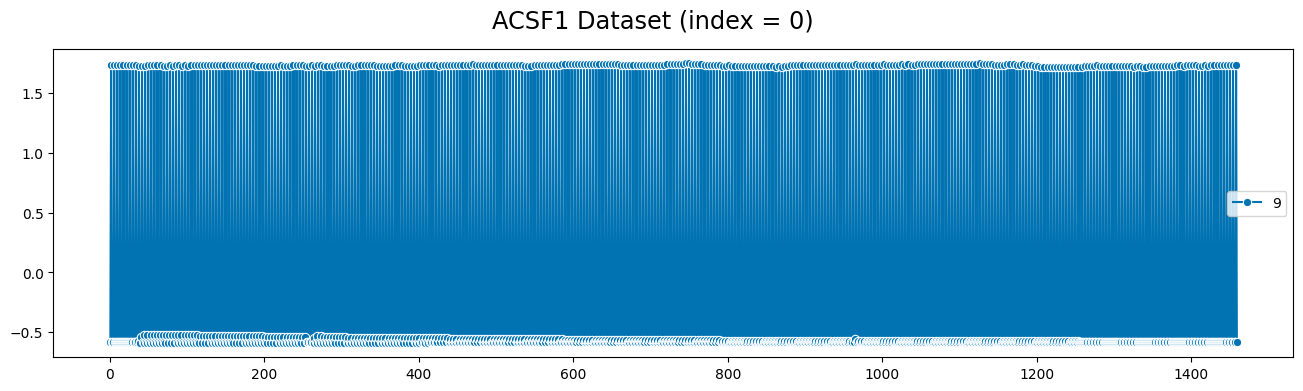

In [11]:
i = 0
plot_series(X_train[i], y_train[i], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

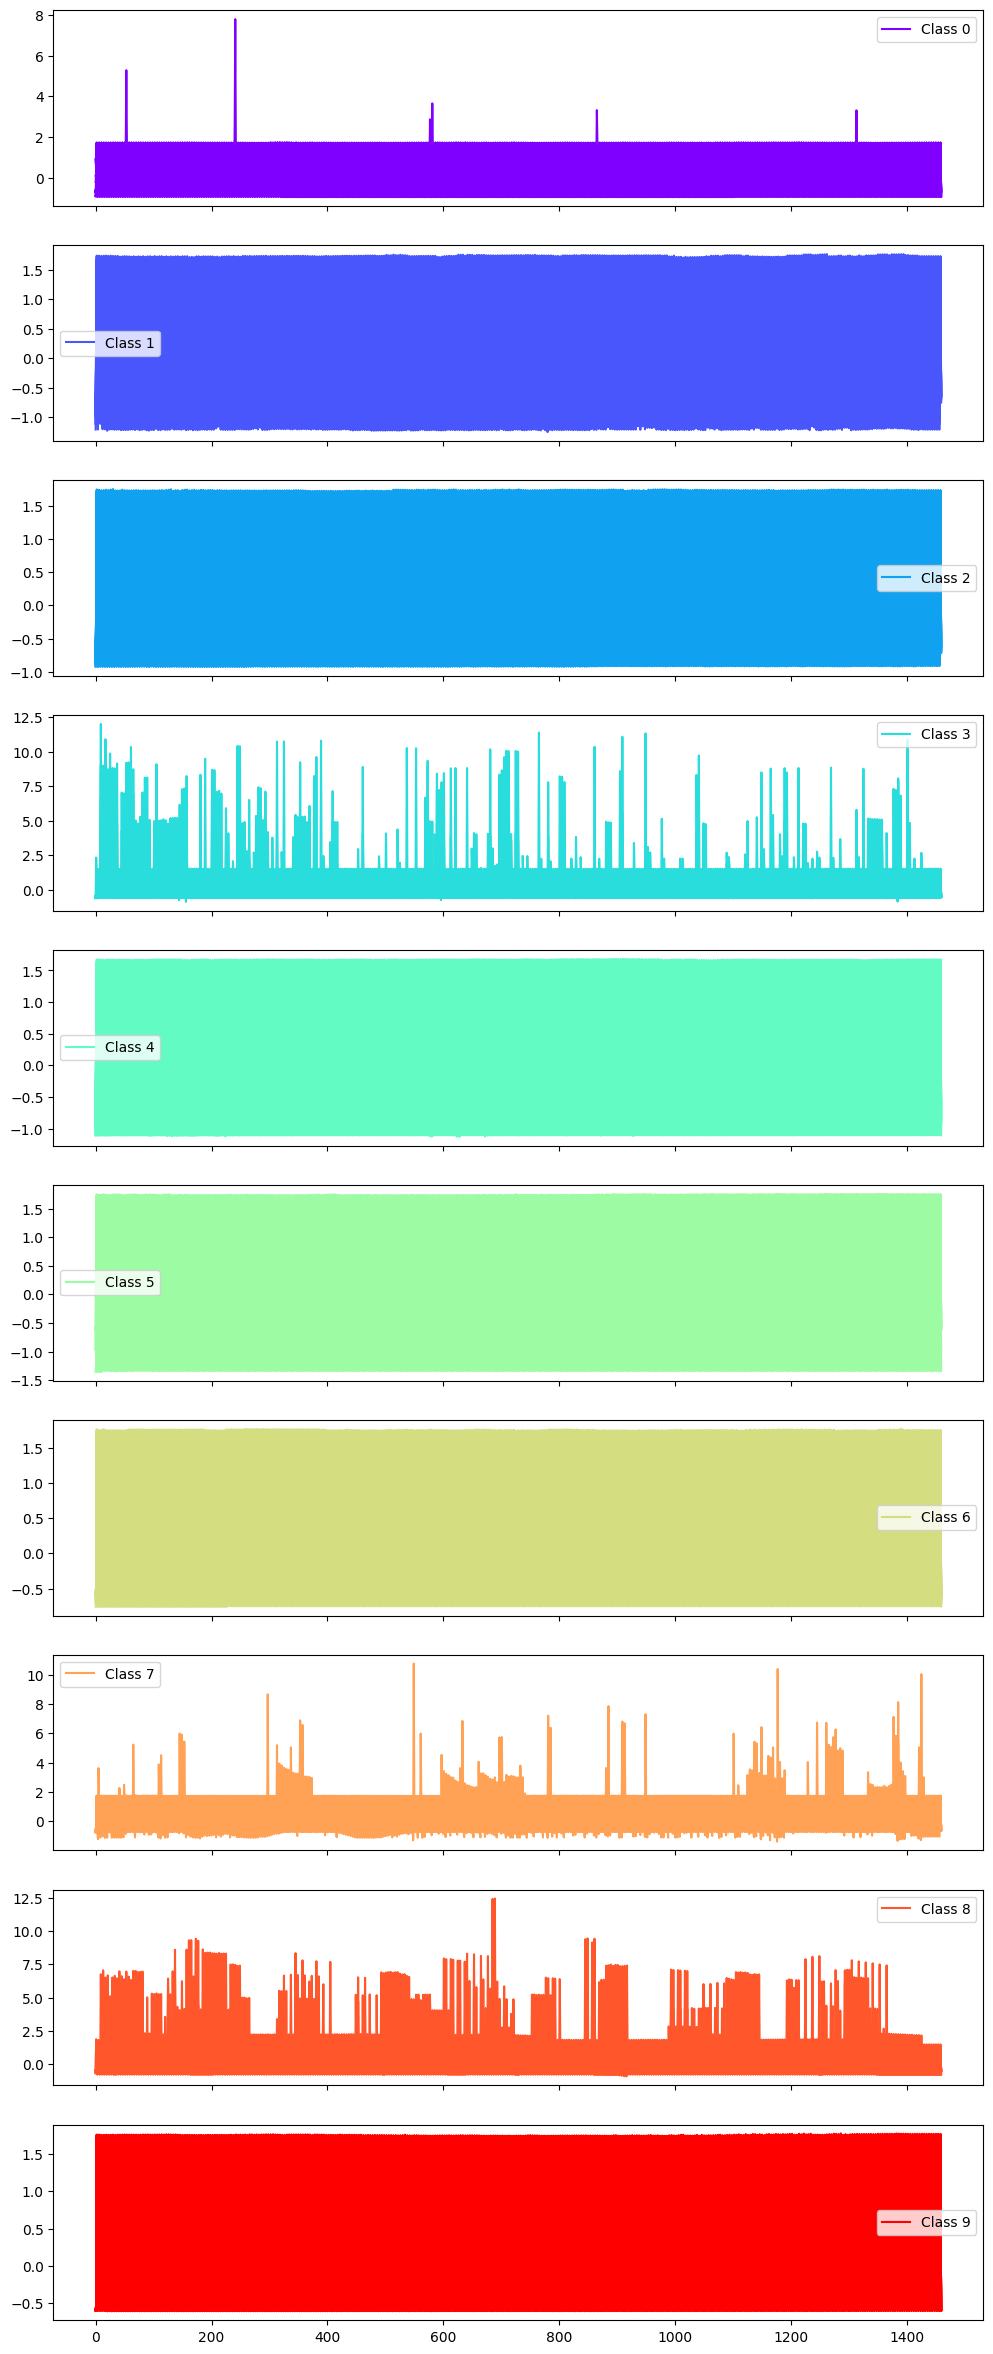

In [12]:
plot_collection_by_class(X, y)
plt.show()

## 4. Dataset: Arrow Head

```bibtex
@inproceedings{ye2009,
  author = {Ye, Lexiang and Keogh, Eamonn},
  title = {Time series shapelets: a new primitive for data mining},
  year = {2009},
  isbn = {9781605584959},
  publisher = {ACM},
  address = {New York, NY, USA},
  url = {https://doi.org/10.1145/1557019.1557122},
  doi = {10.1145/1557019.1557122},
  booktitle = {Proceedings of the 15th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
  pages = {947-–956},
  series = {KDD '09}
}
```

Dataset provided by \cite{ye2009}.

The arrowhead data consists of outlines of the images of arrowheads. The shapes of the projectile points are converted into a time series using the angle-based method. The classification of projectile points is an important topic in anthropology. The classes are based on shape distinctions such as the presence and location of a notch in the arrow. The three classes are called "Avonlea", "Clovis" and "Mix".

<img src="images/00_arrowheads.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

https://www.timeseriesclassification.com/description.php?Dataset=ArrowHead



In [13]:
dataset_name = "ArrowHead"

In [14]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (211, 1, 251)
y.shape: (211,)

X_train shape: (36, 1, 251)
y_train.shape: (36,)
X_test shape: (175, 1, 251)
y_test.shape: (175,)



In [15]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,ArrowHead,36,175,251,3,IMAGE,1,False,False,True,True,True,False,"[0, 1, 2]"


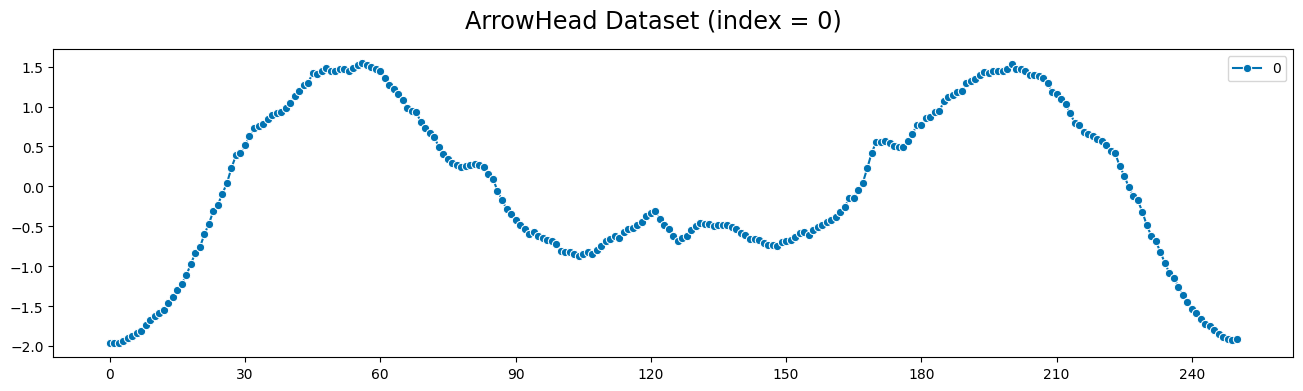

In [16]:
i = 0
plot_series(X_train[i], y_train[i], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

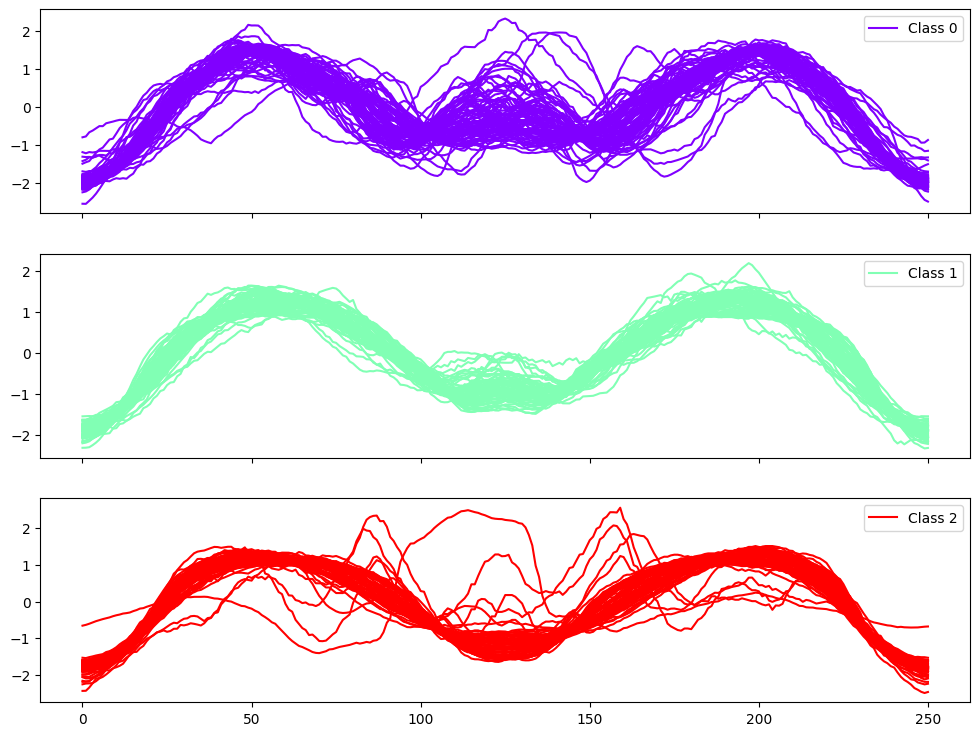

In [17]:
plot_collection_by_class(X, y)
plt.show()

## 5. Dataset: Aconity MINI Printer

```bibtex
@article{mahato2022,
  title = {Detecting voids in 3D printing using melt pool time series data},
  author = {Mahato, Vishal and Obeidi, Mohammad A. and Brabazon, Dermot and others},
  journal = {Journal of Intelligent Manufacturing},
  volume = {33},
  number = {3},
  pages = {845--852},
  year = {2022},
  publisher = {Springer},
  doi = {10.1007/s10845-020-01694-8},
  url = {https://doi.org/10.1007/s10845-020-01694-8}
}
```

Dataset provided by \cite{mahato2022}.

"The two AconityMINIPrinter datasets (small and large) are described in Mahato et al. (2020) and donated by the authors of that paper. The data comes from the AconityMINI 3D printer during the manufacturing of stainless steel blocks with a designed cavity. The problem is to predict whether there is a void in the output of the printer. The time series are temperature data that comes from pyrometers that monitor melt pool temperature. The pyrometers track the scan of the laser to provide a time-series sampled at 100 Hz. The data is sampled from the mid-section of these blocks and is organized into two datasets (large and small). The large dataset covers cubes with large pores (0.4 mm, 0.5 mm, and 0.6 mm) and the small dataset covers cubes with small pores (0.05 mm and 0.1 mm). \cite{middlehurst2024}"

In [18]:
dataset_name = "AconityMINIPrinterLarge"

In [19]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (3587, 1, 300)
y.shape: (3587,)

X_train shape: (2403, 1, 300)
y_train.shape: (2403,)
X_test shape: (1184, 1, 300)
y_test.shape: (1184,)



In [20]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,AconityMINIPrinterLarge,2403,1184,300,2,Multivariate,1,False,False,True,True,True,False,"[0, 1]"


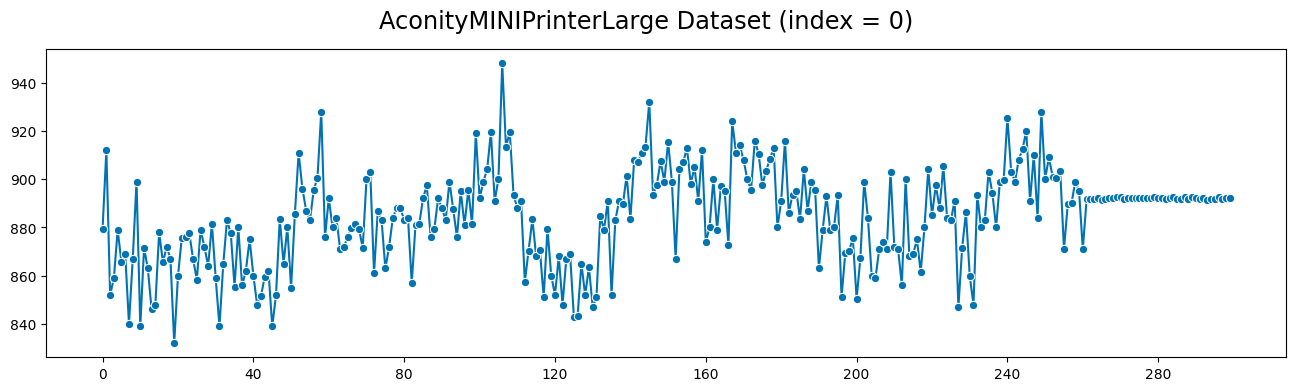

In [21]:
i = 0
plot_series(X_train[i], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

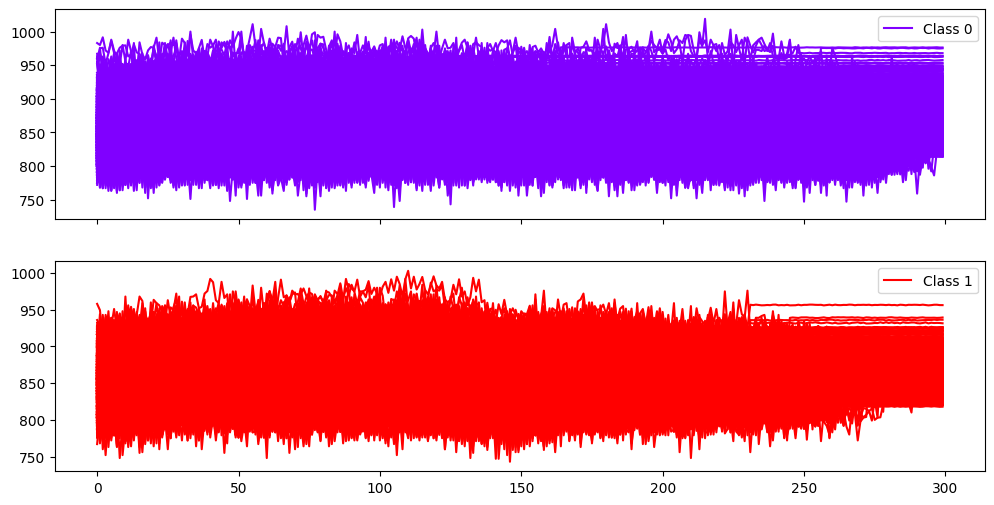

In [22]:
plot_collection_by_class(X, y)
plt.show()

## 6. Dataset: Chlorine Concentration

This dataset was defined in a PhD thesis by Lei Li (Carnegie Mellon University). It was produced by EPANET that models the hydraulic and water quality behavior of water distribution piping systems. EPANET can track, in a given water network, the water level and pressure in each tank, the water flow in the pipes and the concentration of a chemical species (Chlorine in this case) throughout the network within a simulated duration. The data set consists of 166 nodes (pipe junctions) and measurement of the Chlorine concentration level at all these nodes during 15 days (one measurement for every 5 minutes, a total of 4310 time ticks).

https://www.timeseriesclassification.com/description.php?Dataset=ChlorineConcentration

In [23]:
dataset_name = "ChlorineConcentration"

In [24]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (4307, 1, 166)
y.shape: (4307,)

X_train shape: (467, 1, 166)
y_train.shape: (467,)
X_test shape: (3840, 1, 166)
y_test.shape: (3840,)



In [25]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,ChlorineConcentration,467,3840,166,3,SIMULATED,1,False,False,True,True,True,False,"[1, 2, 3]"


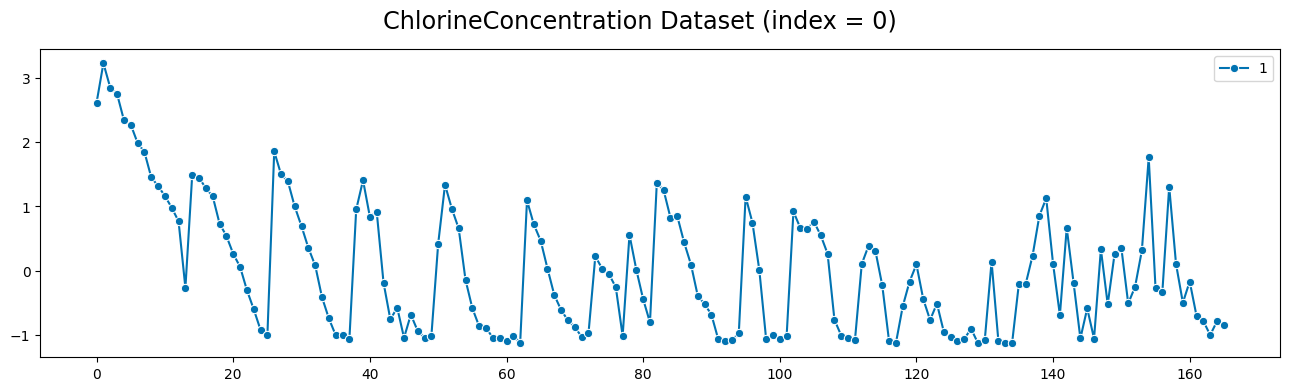

In [26]:
i = 0
plot_series(X_train[i], y_train[i], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

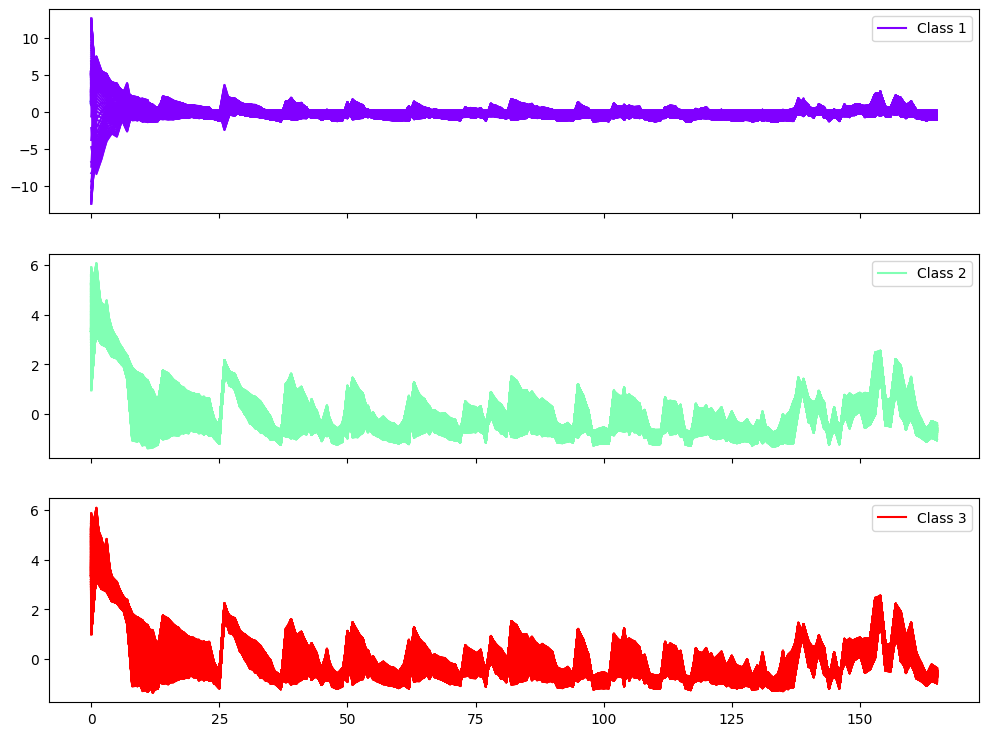

In [27]:
plot_collection_by_class(X, y)
plt.show()

## 7. Dataset: Asphalt

```bibtex
@article{souza2018,
  title = {Asphalt pavement classification using smartphone accelerometer and Complexity Invariant Distance},
  journal = {Engineering Applications of Artificial Intelligence},
  volume = {74},
  pages = {198--211},
  year = {2018},
  issn = {0952-1976},
  doi = {https://doi.org/10.1016/j.engappai.2018.06.003},
  url = {https://www.sciencedirect.com/science/article/pii/S0952197618301349},
  author = {Vinicius M.A. Souza},
}
```

Dataset provided by \cite{souza2018}.

Accelerometer data was collected on a smartphone installed inside a vehicle using a flexible suction holder near the dashboard. An expert was responsible for driving the vehicle while the device ran an Android application called Asfault, developed specifically to store the current asphalt condition continuously over time. Asfault stores the time-stamp of the collected data, acceleration forces in along the three physical axes, latitude, longitude, and velocity.

The acceleration forces are given by the accelerometer sensor of the device and are the data used for the classification task. Latitude, longitude, and velocity are given by the GPS and are used to locate the collected/classified data. Each one of this information is a different continuous time series. A sampling rate of 100 Hz was used for each time series. It is important to note that the Android system does not guarantee a perfect precision on the interval between readings. This means that when we choose a sampling rate of 100 Hz, the device should output between 95 and 105 observations per second.

This data contains the multivariate (X,Y,Z) time series.

In order to obtain labeled data, the Asfault application allows the expert to inform the pavement condition before collecting the data. To guarantee the integrity of data, Asfault also records videos of the road over the data collection using the built-in camera. Thus, it is possible to perform the analysis of these videos to confirm the class labels assigned by the expert.

The datasets were collected in the Brazilian cities of Sao Carlos, Ribeirao Preto, Araraquara, and Maringa using a medium sized hatchback car (Hyundai i30) and two different devices (Samsung Galaxy A5 and Samsung S7).

The problem AsphaltObstacles involves the identification of four common obstacles in the region of data collection. It has the following class labels:

- raised_crosswalk (160 cases);
- raised_markers (187 cases);
- speed_bump (212 cases); and
- vertical_patch (222 cases).

Data is variable length, minimum 111 observations, maximum 736. The data is split randomly into 50/50 default train series. The data can be resampled without bias.

<img src="images/00_asphalt.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

https://www.timeseriesclassification.com/description.php?Dataset=AsphaltObstaclesCoordinates

In [28]:
dataset_name = "AsphaltObstaclesCoordinates"

In [29]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (781, 'unknown')
y.shape: (781,)

X_train shape: (390, 'unknown')
y_train.shape: (390,)
X_test shape: (391, 'unknown')
y_test.shape: (391,)



In [30]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,AsphaltObstaclesCoordinates,390,391,0,4,MOTION,3,False,False,False,False,True,False,"[raised_crosswalk, raised_markers, speed_bump,..."


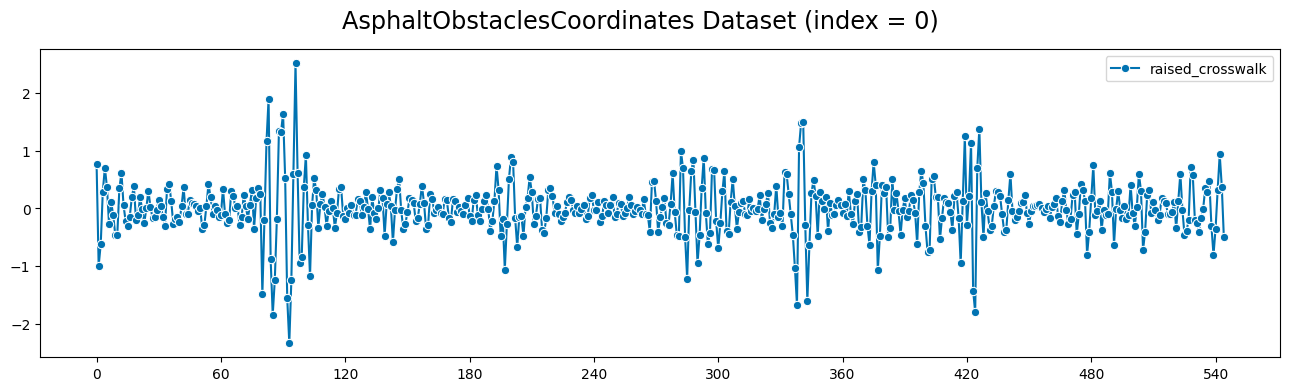

In [31]:
i = 0
plot_series(X_train[i][0], [y_train[i]], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

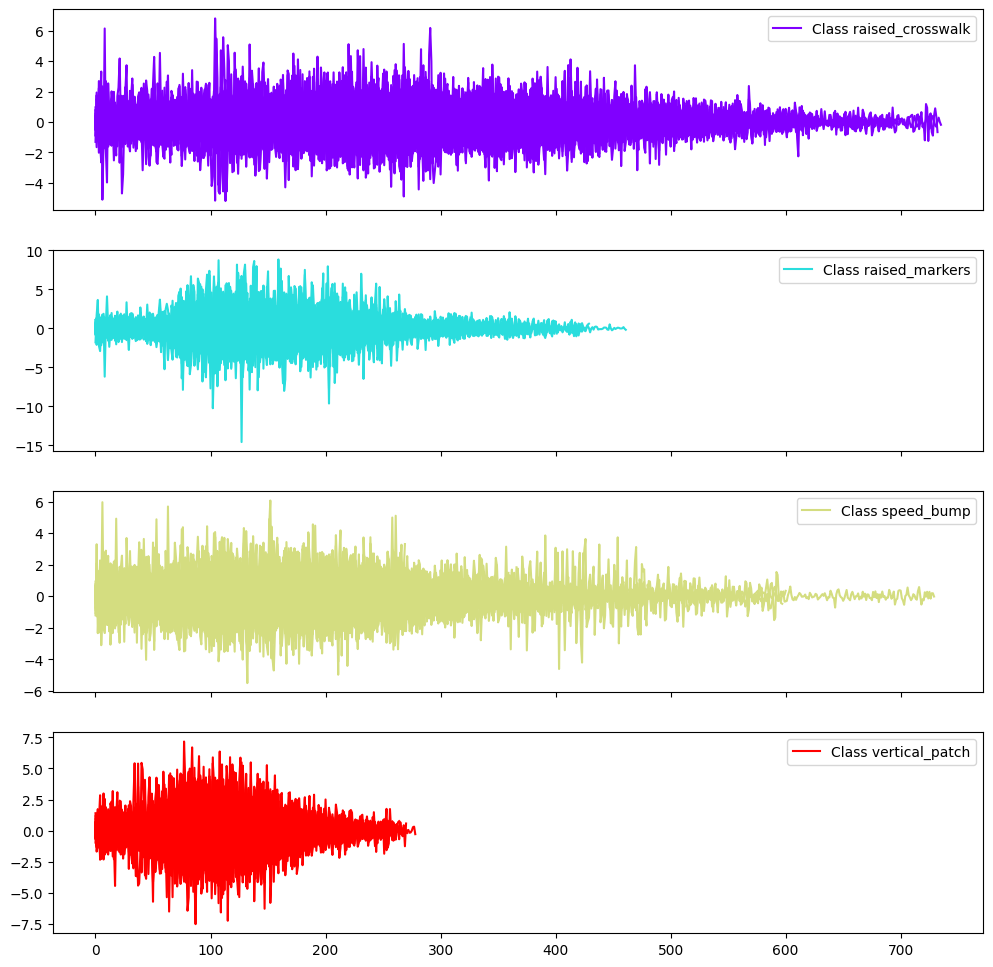

In [32]:
plot_collection_by_class(X, y)
plt.show()

## 8. Dataset: Colposcopy

```bibtex
@article{fragoso2017,
  title = {Optimization of Classification Strategies of Acetowhite Temporal Patterns towards Improving Diagnostic Performance of Colposcopy},
  author = {Gutiérrez-Fragoso, Karina and Acosta-Mesa, Héctor and Cruz-Ramírez, Nicandro and Hernández-Jiménez, Rodolfo},
  year = {2017},
  month = {07},
  pages = {1--10},
  volume = {2017},
  journal = {Computational and Mathematical Methods in Medicine},
  doi = {10.1155/2017/5989105}
}
```

Dataset provided by \cite{fragoso2017}.

The task is to classify the nature of a diagnosis from a colposcopy. The time series represent the change in intensity values of a pixel region through a sequence of digital colposcopic images obtained during the colposcopy test that was performed on each patient included in the study.

The colposcopic image sequence can be represented as a sequence of 2D images I(x, y) with acquisition time t. Therefore, there are (x*y) pixels, and the intensity value I of each pixel over time is used to construct a time series of length t (acetowhite response function (Awrf)).

<img src="images/00_colposcopy.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

https://onlinelibrary.wiley.com/doi/full/10.1155/2017/5989105

In [33]:
dataset_name = "Colposcopy"

In [34]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (200, 1, 180)
y.shape: (200,)

X_train shape: (99, 1, 180)
y_train.shape: (99,)
X_test shape: (101, 1, 180)
y_test.shape: (101,)



In [35]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,Colposcopy,100,100,180,6,IMAGE,1,False,False,True,True,True,False,"[0, 1, 2, 3, 4, 5]"


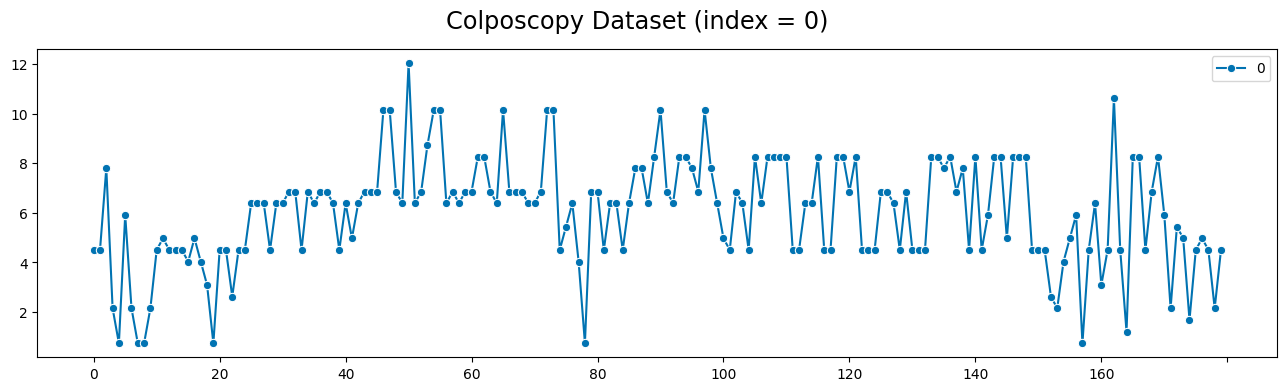

In [36]:
i = 0
plot_series(X_train[i][0], [y_train[i]], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

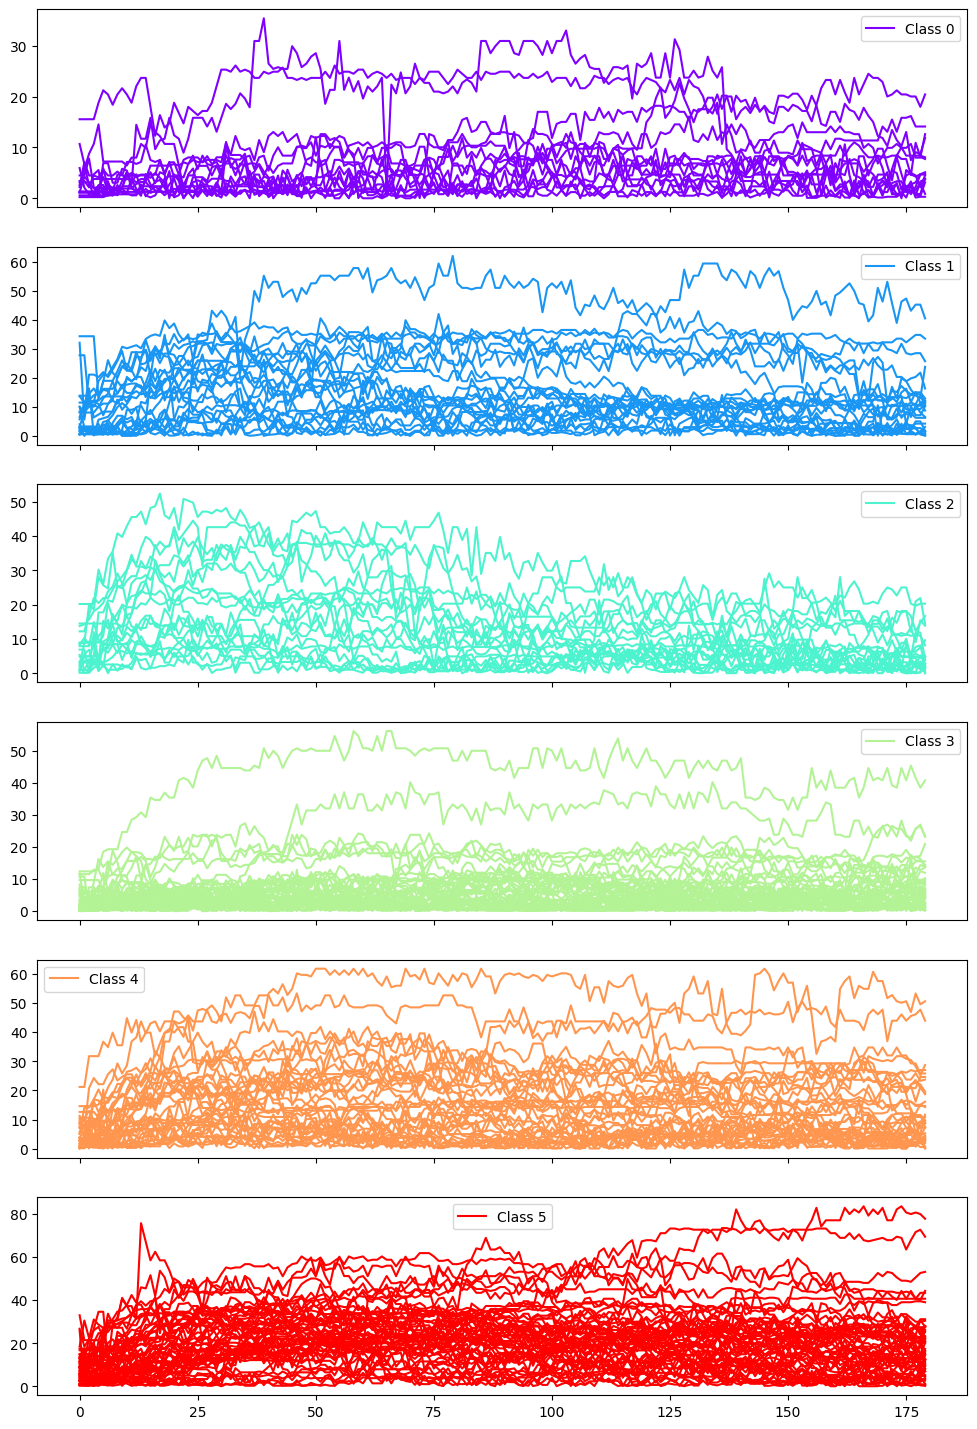

In [37]:
plot_collection_by_class(X, y)
plt.show()

## 9. Dataset: Melbourne Pedestrian

The City of Melbourne, Australia has developed an automated pedestrian counting system to better understand pedestrian activity within the municipality, such as how people use different city locations at different time of the day. The data analysis can facility decision making and urban planning for the future. We extract data of 10 locations for the whole year 2017. 
Data are pedestrian count for 12 months of the year 2017. Classes correspond location of sensor placement. 
- Class 1: Bourke Street Mall (North) 
- Class 2: Southern Cross Station 
- Class 3: New Quay 
- Class 4: Flinders St Station Underpass 
- Class 5: QV Market-Elizabeth (West) 
- Class 6: Convention/Exhibition Centre 
- Class 7: Chinatown-Swanston St (North) 
- Class 8: Webb Bridge 
- Class 9: Tin Alley-Swanston St (West) 
- Class 10: Southbank

There is nothing to infer from the order of examples in the train and test set

https://www.timeseriesclassification.com/description.php?Dataset=MelbournePedestrian

In [38]:
dataset_name = "MelbournePedestrian"

In [39]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (3457, 1, 24)
y.shape: (3457,)

X_train shape: (1138, 1, 24)
y_train.shape: (1138,)
X_test shape: (2319, 1, 24)
y_test.shape: (2319,)



In [40]:
X_train = X_train.squeeze(1)
X_test = X_test.squeeze(1)

In [41]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,MelbournePedestrian,1194,2439,24,10,TRAFFIC,1,False,False,True,True,True,False,"[1, 10, 2, 3, 4, 5, 6, 7, 8, 9]"


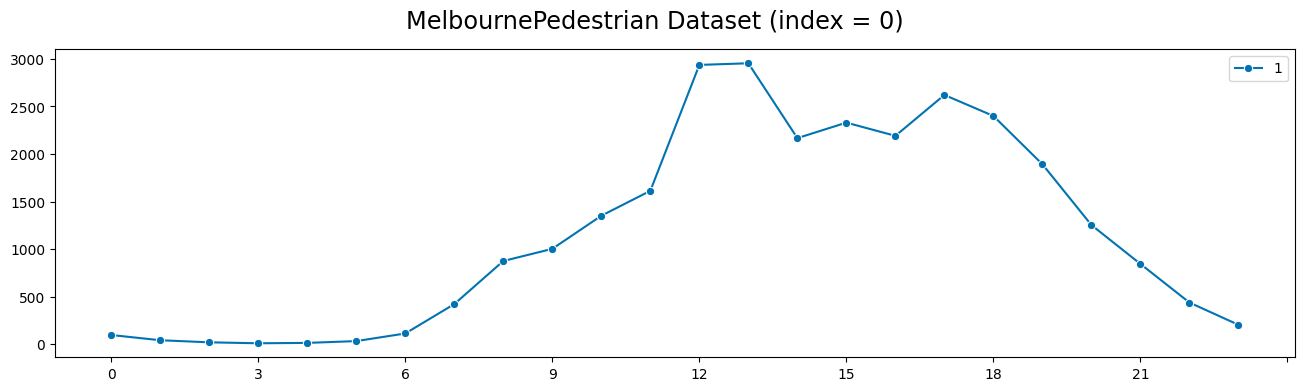

In [42]:
i = 0
plot_series(X_train[i], [y_train[i]], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

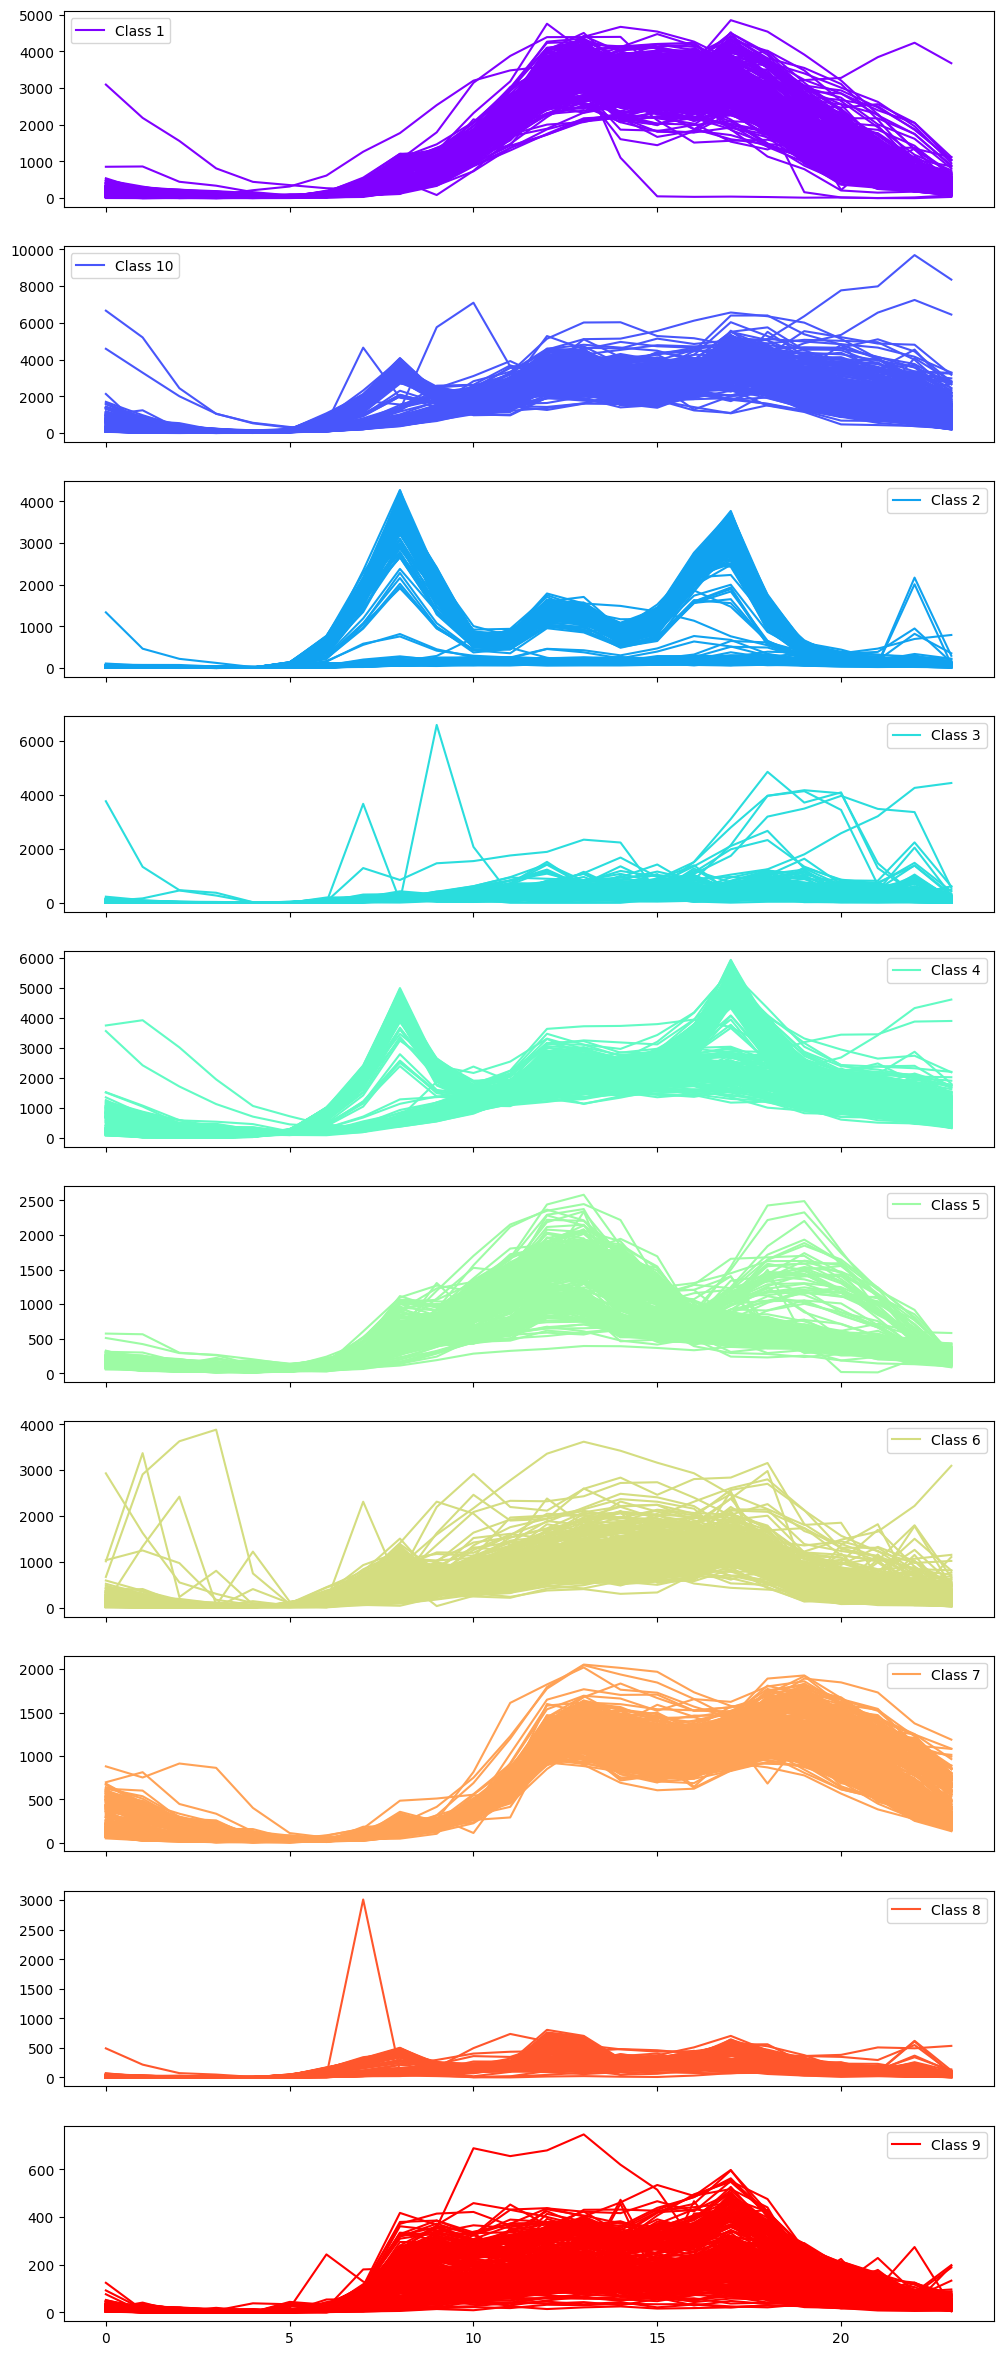

In [43]:
plot_collection_by_class(X, y)
plt.show()

## 10. Dataset: Share Price Increase

The problem here is to predict whether a share price will show an exceptional rise after quarterly announcement of the Earning Per Share based on the price movement of that share price on the proceeding 60 days? The data was formatted by Vlad Pazenuks as part of his third year project. Daily price data on NASDAQ 100 companies was extracted from a Kaggle data set. Reporting dates of these companies were obtained from NASDAQ.com. Each data is the percentage change of the close price from the day before. Each case is a series of 60 day data. The target class is is defined as 0 = price did not increase after company report release by more than 5 percent 1 = price increased after company report release by more than 5 percent There are 1931 cases, 1326 class 0 and 605 class 1.

https://www.timeseriesclassification.com/description.php?Dataset=SharePriceIncrease

In [44]:
dataset_name = "SharePriceIncrease"

In [45]:
X, y, X_train, y_train, X_test, y_test, metadata_df = get_datasets_and_metadata(dataset_name)

X shape: (1931, 1, 60)
y.shape: (1931,)

X_train shape: (965, 1, 60)
y_train.shape: (965,)
X_test shape: (966, 1, 60)
y_test.shape: (966,)



In [46]:
metadata_df

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels,Timestamps,Missing,Univariate,EqualLength,ClassLabel,TargetLabel,ClassValues
0,SharePriceIncrease,965,965,60,2,FINANCIAL,1,False,False,True,True,True,False,"[0, 1]"


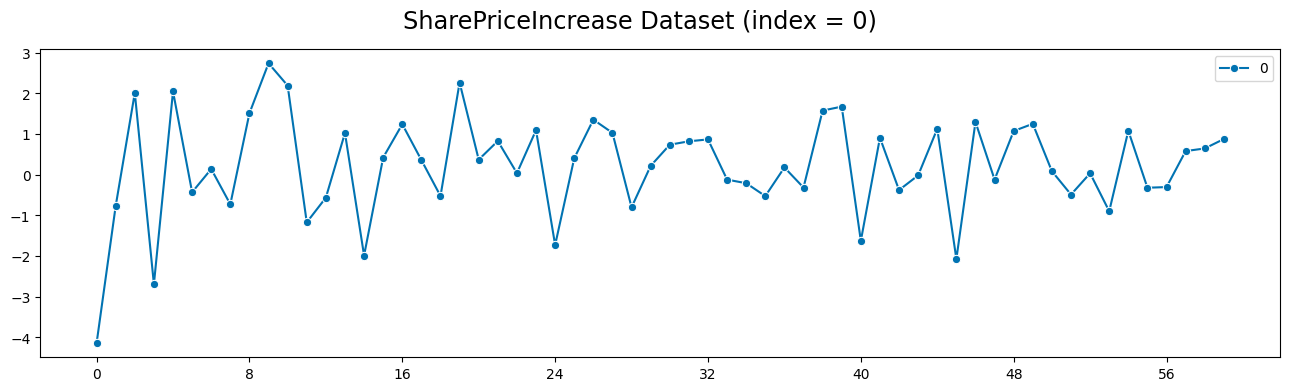

In [47]:
i = 0
plot_series(X_train[i][0], [y_train[i]], title=f"{dataset_name} Dataset (index = {i})")
plt.show()

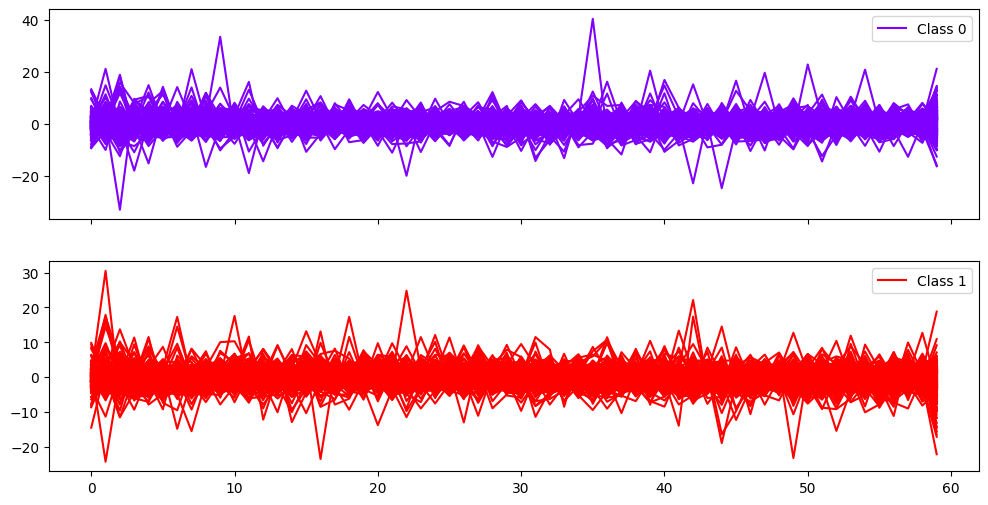

In [48]:
plot_collection_by_class(X, y)
plt.show()